In [10]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('assignment3data.csv', parse_dates=['date'], index_col='date')
df.fillna(method='ffill', inplace=True)  # 前向填充缺失值
# 对风向进行独热编码
df = pd.get_dummies(df, columns=['wnd_dir'], prefix='wind')
target = df['pollution'].values
features = df.drop('pollution', axis=1).values

# 标准化特征
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

C:\Users\16323\AppData\Local\Temp\ipykernel_27372\802693759.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # 前向填充缺失值


In [ ]:
def create_sequences(features, target, n_steps=3):
    X, y = [], []
    for i in range(len(features) - n_steps):
        X.append(features[i:i+n_steps]) 
        y.append(target[i+n_steps])    
    return np.array(X), np.array(y)

n_steps = 3  # 时间窗口大小
X, y = create_sequences(scaled_features, target, n_steps)
split = int(0.8 * len(X))# 80%训练集，20%测试集
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [12]:

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# 创建数据集和数据加载器
batch_size = 32
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [13]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            batch_first=True  # 输入形状为 (batch, seq_len, features)
        )
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.lstm(x)          # 输出形状: (batch, seq_len, hidden_size)
        out = out[:, -1, :]            # 取最后一个时间步的输出
        out = self.dropout(out)
        out = self.linear(out)         # 输出形状: (batch, output_size)
        return out

# 初始化模型
input_size = X_train.shape[2]  # 特征数量
hidden_size = 50
model = LSTMModel(input_size, hidden_size)
print(model)

LSTMModel(
  (lstm): LSTM(10, 50, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)


In [ ]:
# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# 训练参数
num_epochs = 30
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
#记录每个epoch的损失
train_losses = []
test_losses = []

# 训练循环
for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0  # 新增：累计每个epoch的训练损失
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        # 前向传播
        outputs = model(batch_X)
        loss = criterion(outputs.squeeze(), batch_y)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item() * batch_X.size(0)  # 累计损失
    
    # 计算每个epoch的平均训练损失
    epoch_train_loss /= len(train_loader.dataset)
    train_losses.append(epoch_train_loss)  # 保存训练损失
    
    # 验证集损失
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            test_loss += criterion(outputs.squeeze(), batch_y).item() * batch_X.size(0)
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)  # 保存测试损失
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Test Loss: {test_loss:.4f}')

Epoch [1/50], Train Loss: 12423.5293, Test Loss: 10225.5556
Epoch [2/50], Train Loss: 8324.3608, Test Loss: 7839.5262
Epoch [3/50], Train Loss: 6869.5551, Test Loss: 6940.2577
Epoch [4/50], Train Loss: 6308.2405, Test Loss: 6535.4856
Epoch [5/50], Train Loss: 6038.3389, Test Loss: 6292.5204
Epoch [6/50], Train Loss: 5874.6195, Test Loss: 6139.2404
Epoch [7/50], Train Loss: 5753.4887, Test Loss: 5999.6830
Epoch [8/50], Train Loss: 5676.0452, Test Loss: 5956.5701
Epoch [9/50], Train Loss: 5595.7110, Test Loss: 5885.5509
Epoch [10/50], Train Loss: 5536.4524, Test Loss: 5797.2310
Epoch [11/50], Train Loss: 5489.8236, Test Loss: 5931.2740
Epoch [12/50], Train Loss: 5471.2999, Test Loss: 5963.8409
Epoch [13/50], Train Loss: 5440.7203, Test Loss: 5895.0665
Epoch [14/50], Train Loss: 5401.7733, Test Loss: 5884.7785
Epoch [15/50], Train Loss: 5368.1472, Test Loss: 5801.3528
Epoch [16/50], Train Loss: 5358.4655, Test Loss: 5817.6071
Epoch [17/50], Train Loss: 5338.9069, Test Loss: 5921.7186
Epoc

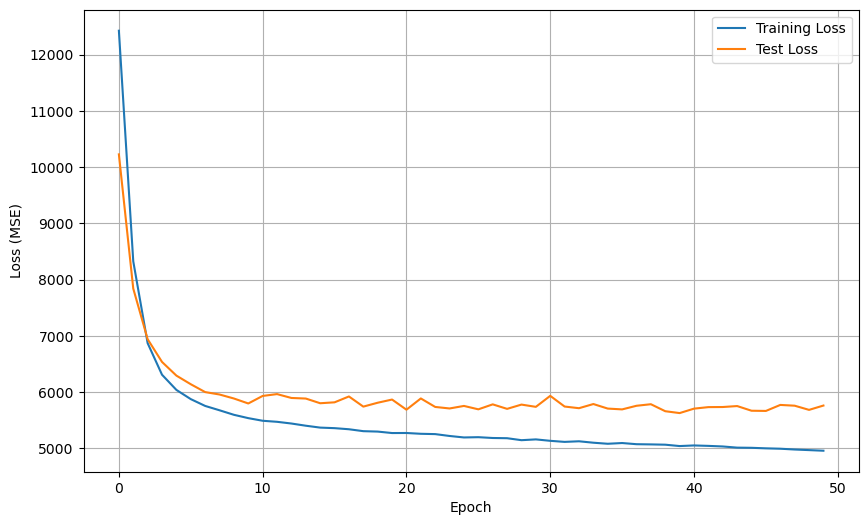

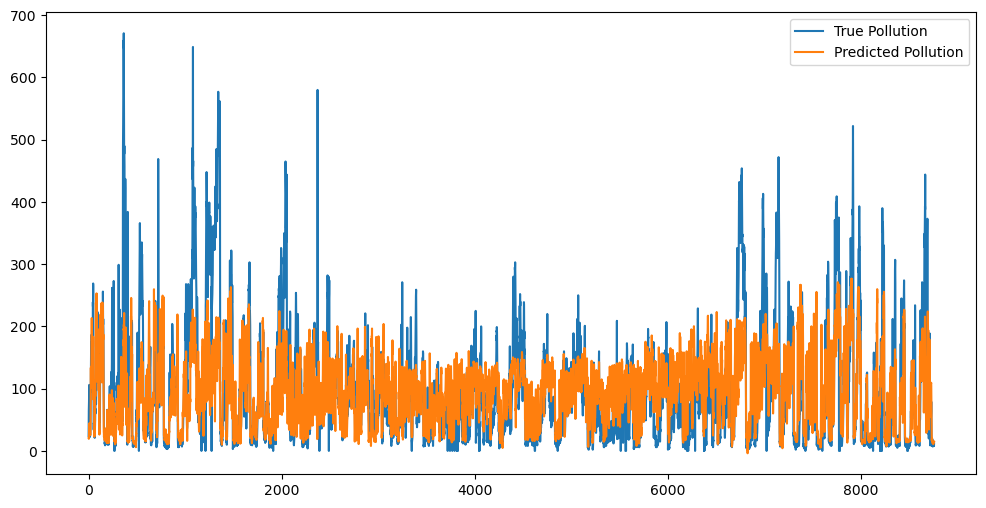

Mean Squared Error: 5760.22


In [15]:
# 可视化损失曲线
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()
model.eval()
y_pred = []
with torch.no_grad():
    for batch_X, _ in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        y_pred.extend(outputs.cpu().numpy().squeeze())

y_pred = np.array(y_pred)
y_test_np = y_test  # 原始目标值
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test_np, label='True Pollution')
plt.plot(y_pred, label='Predicted Pollution')
plt.legend()
plt.show()
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test_np, y_pred)
print(f"Mean Squared Error: {mse:.2f}")